Dataset Shape: (7043, 21)

Data Types:
customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                 int64
dtype: object

Missing Values:
customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract    

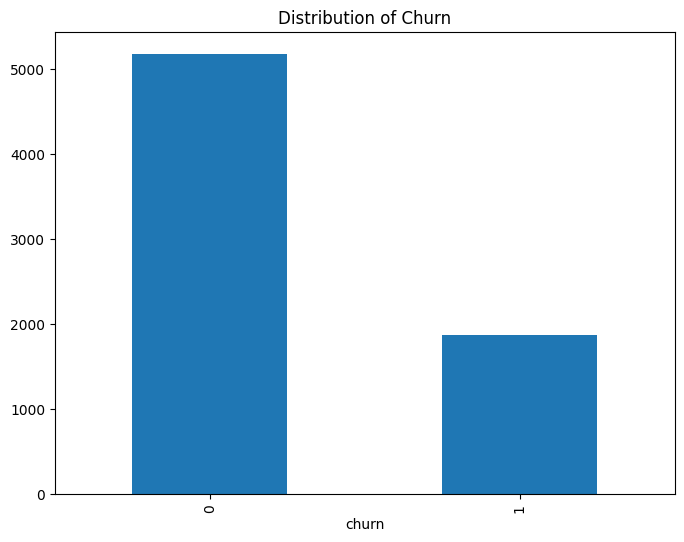

<Figure size 1500x1000 with 0 Axes>

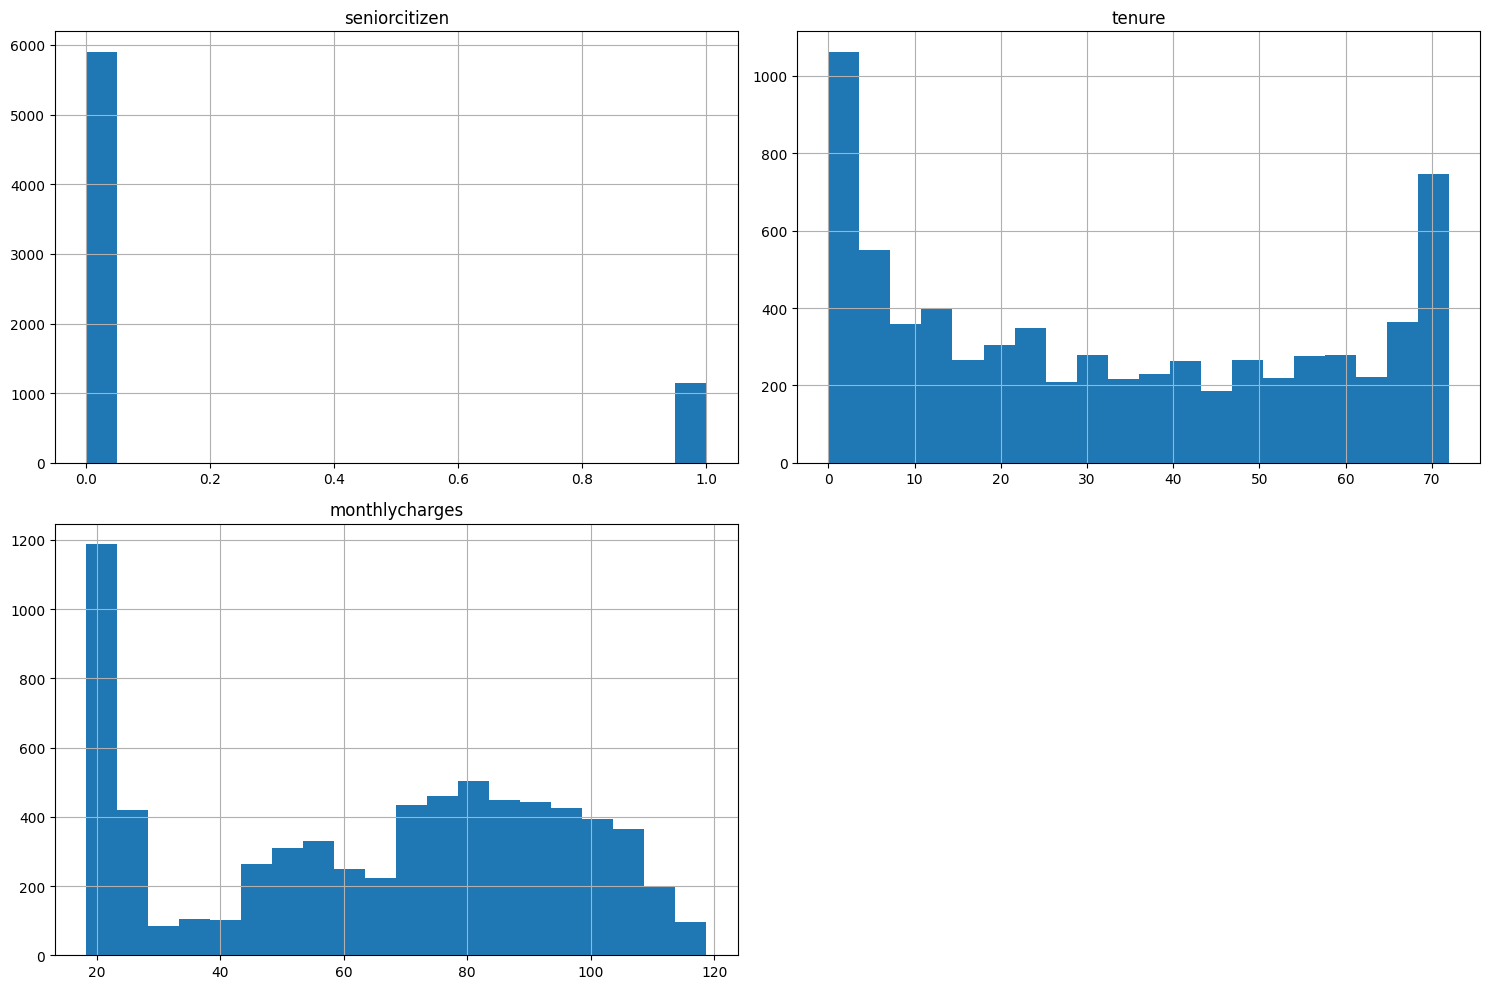

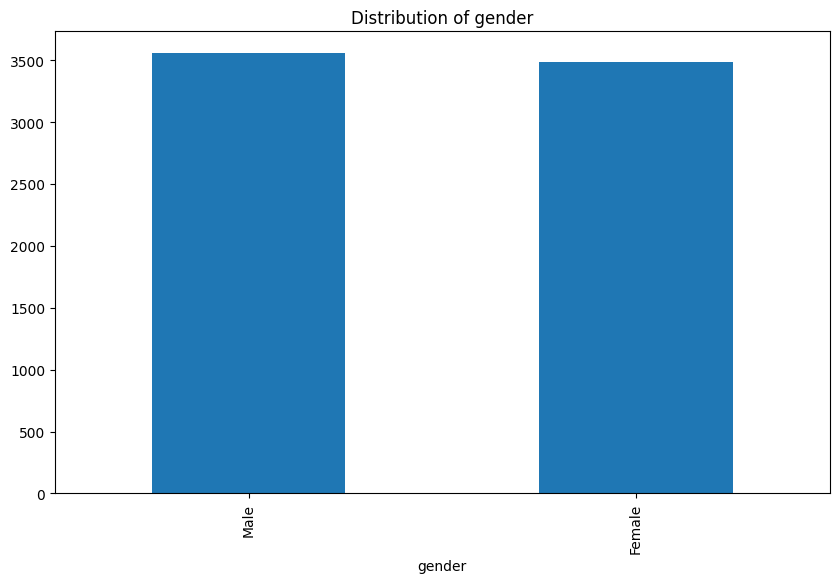

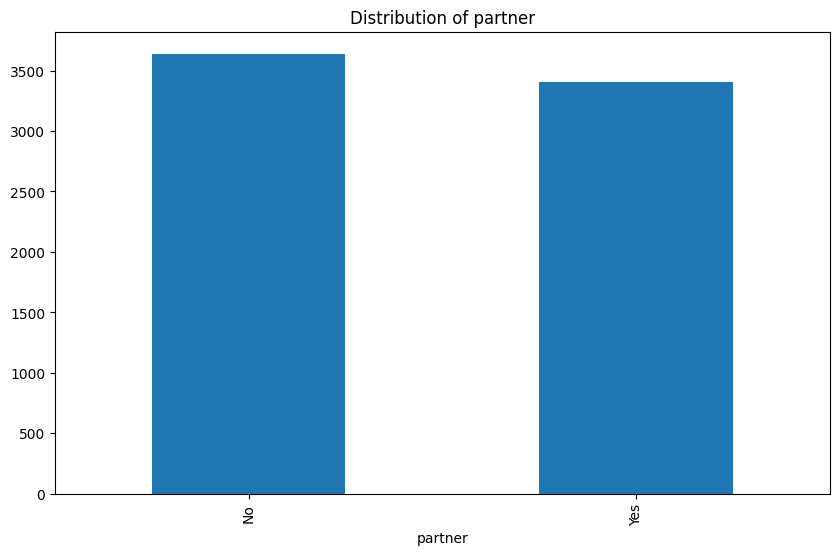

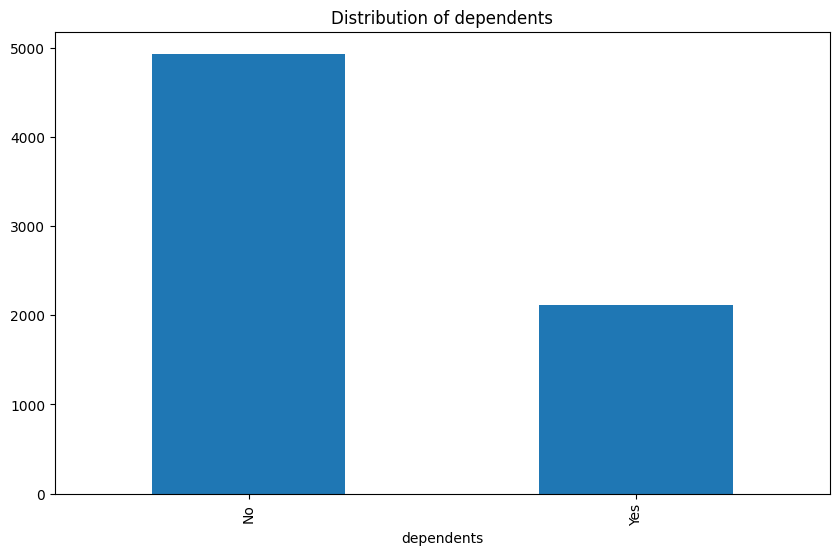

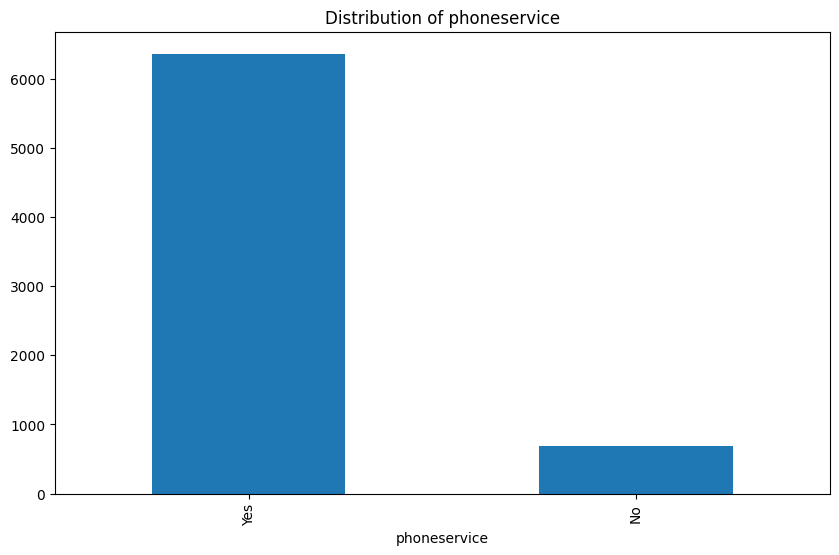

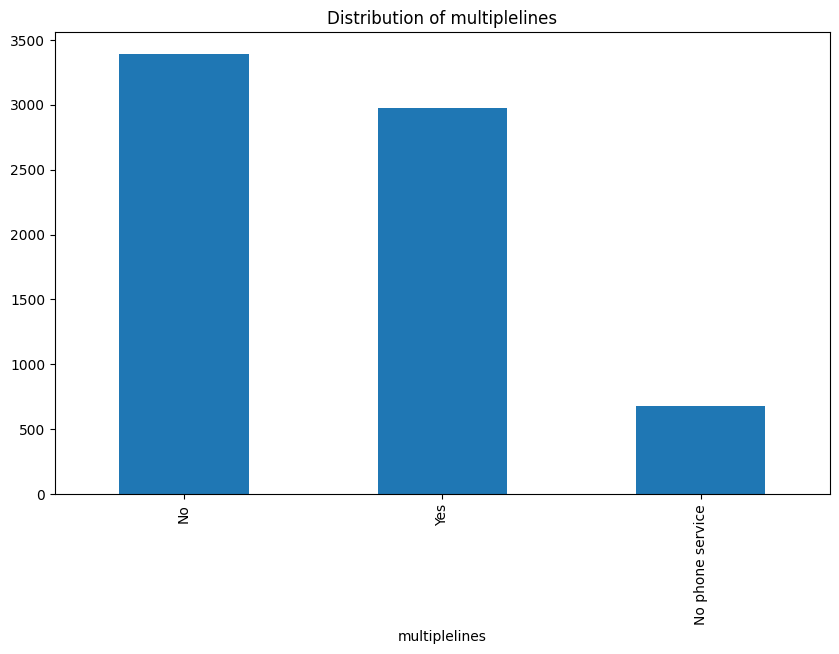

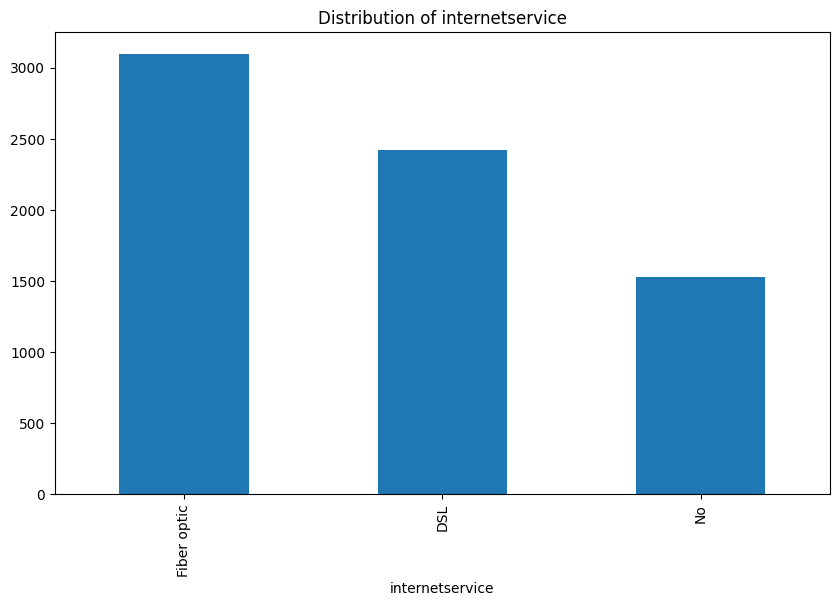

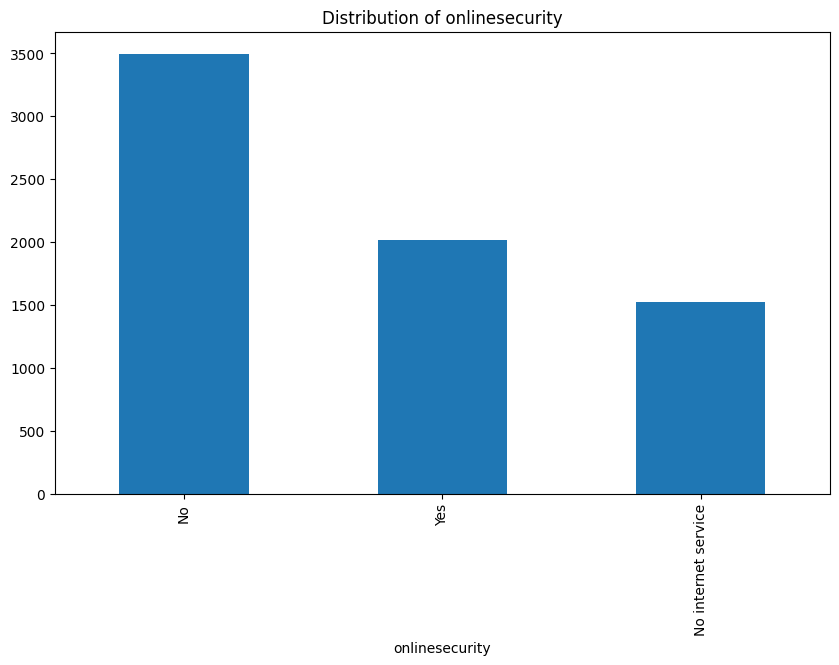

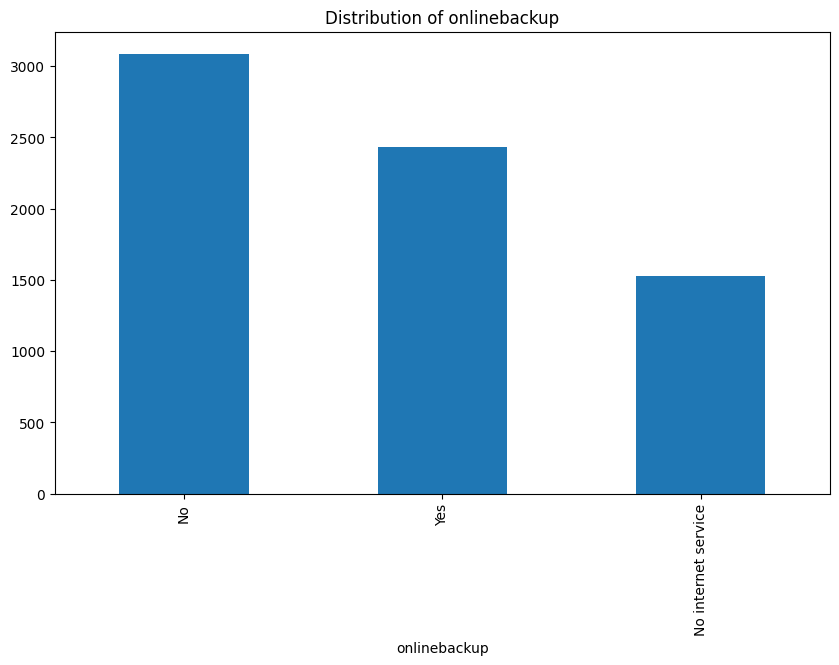

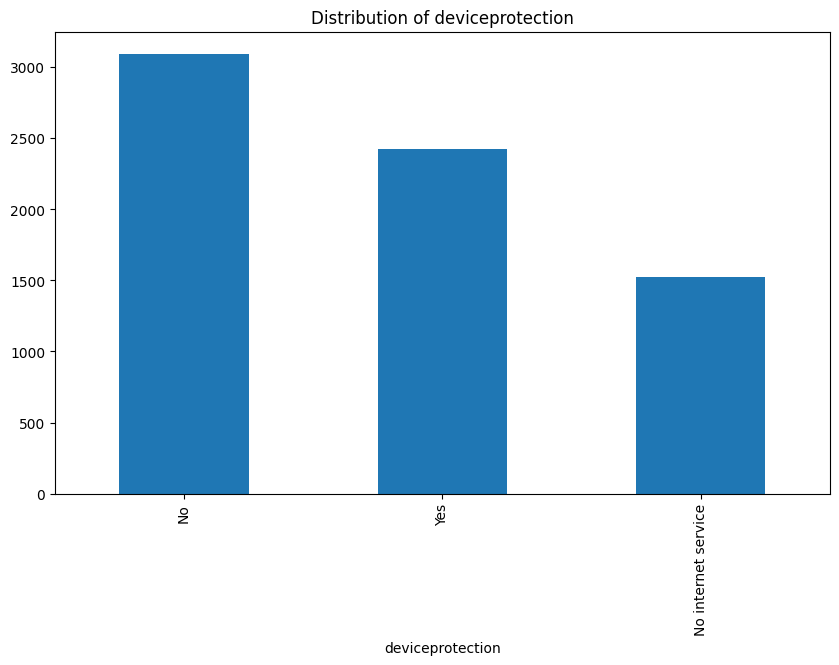

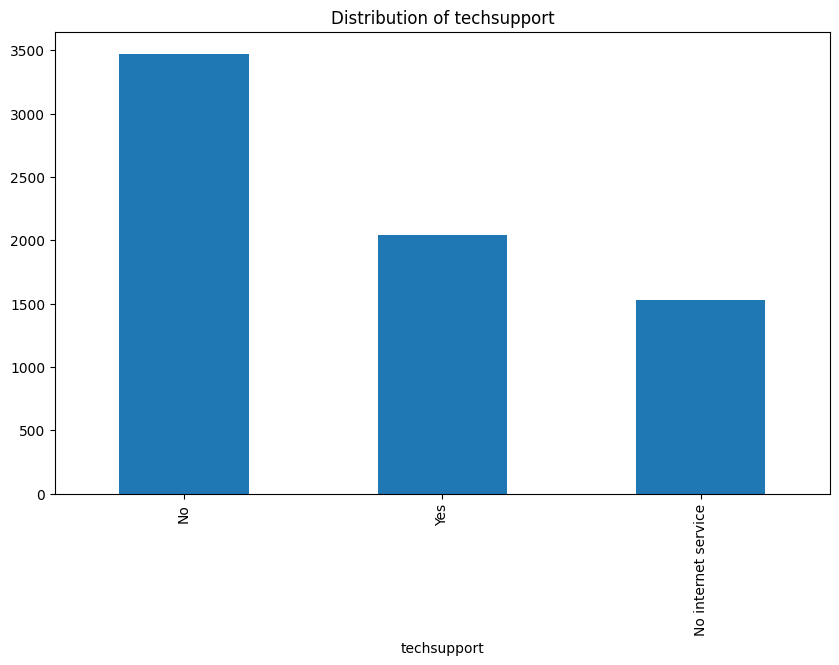

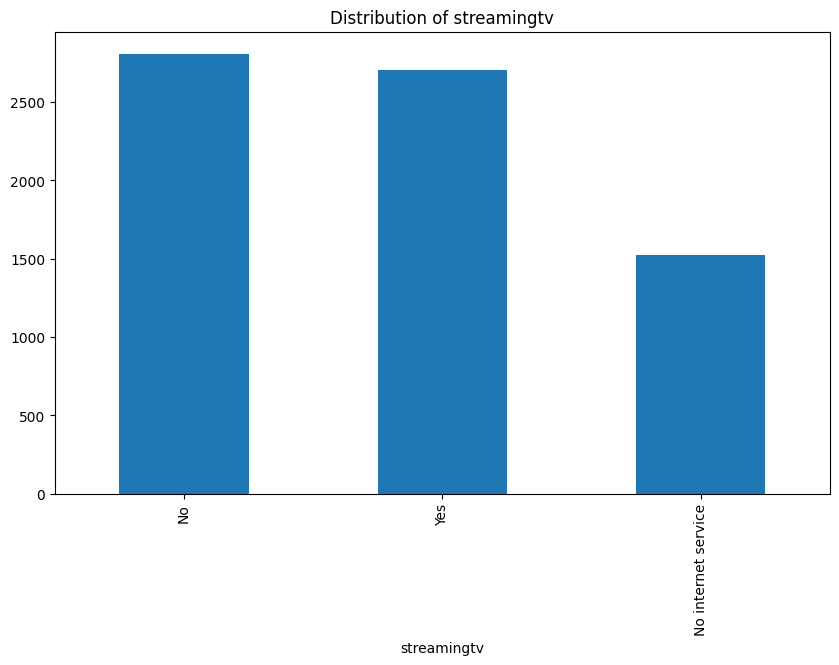

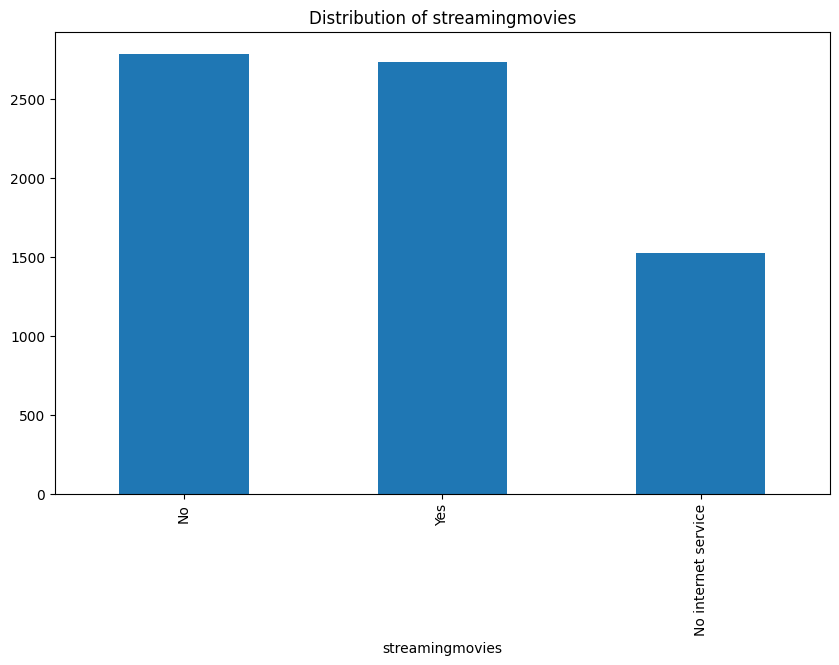

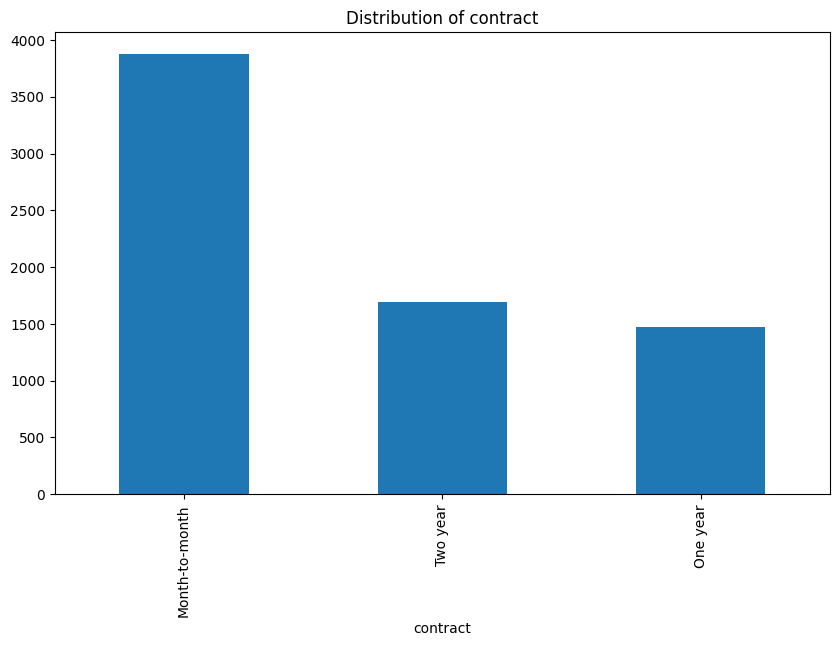

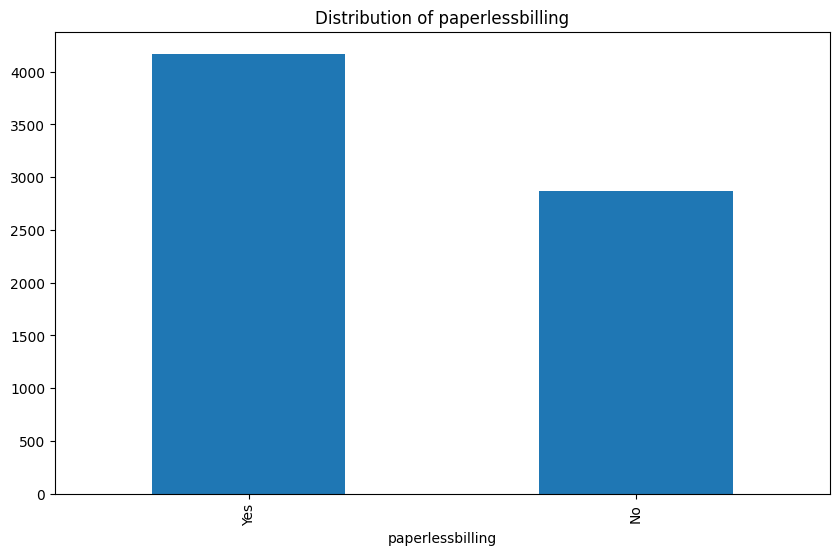

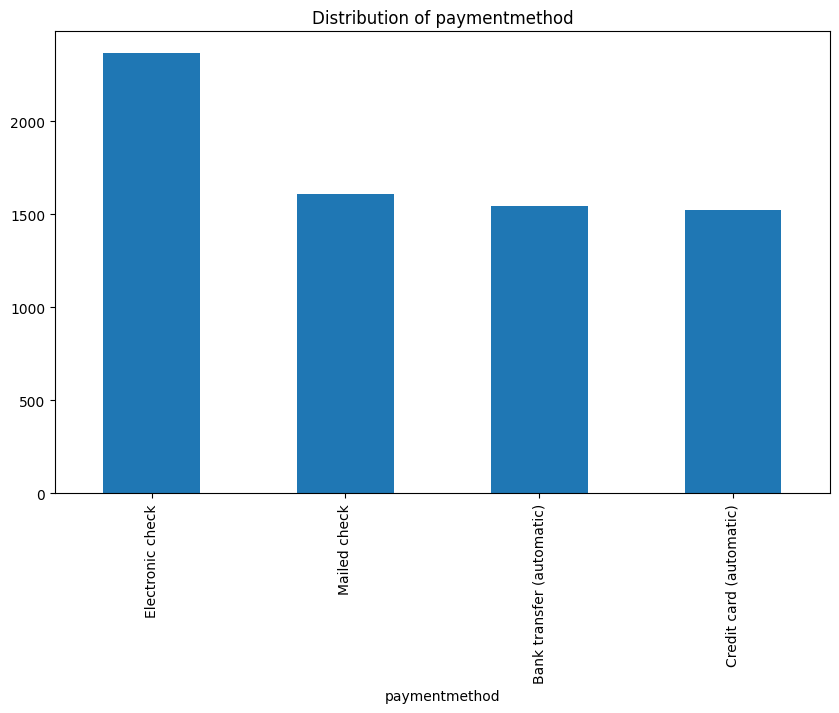

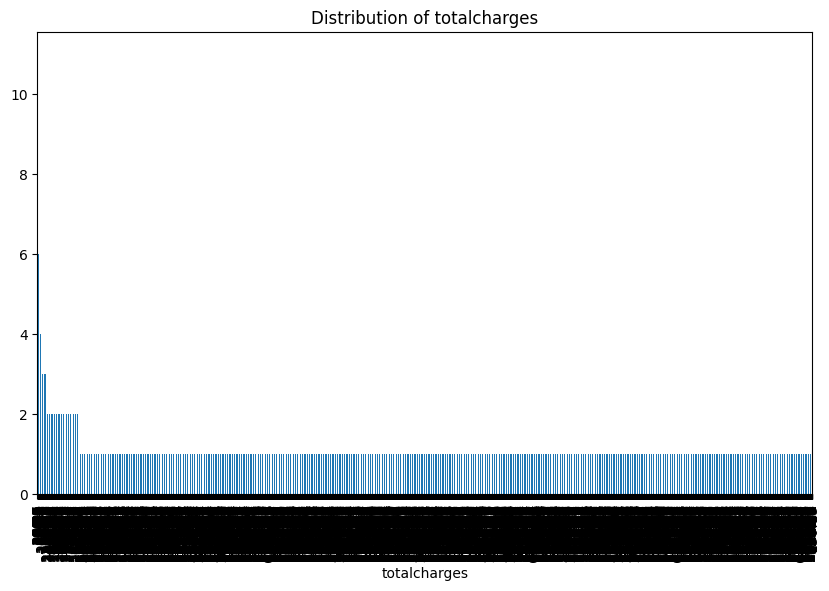

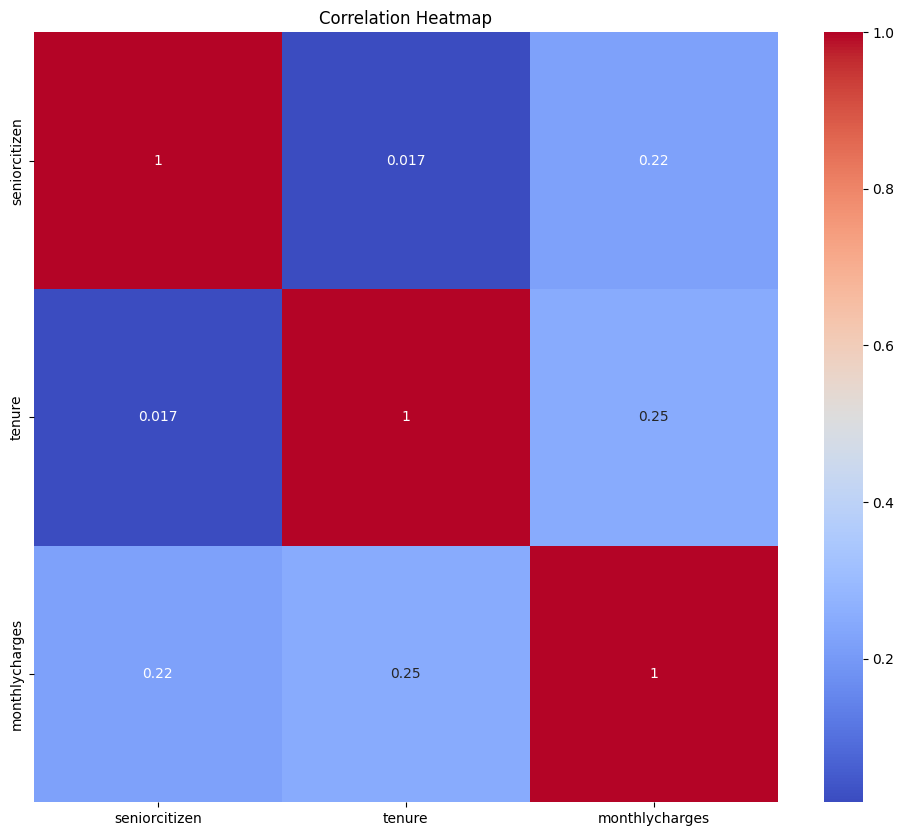

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


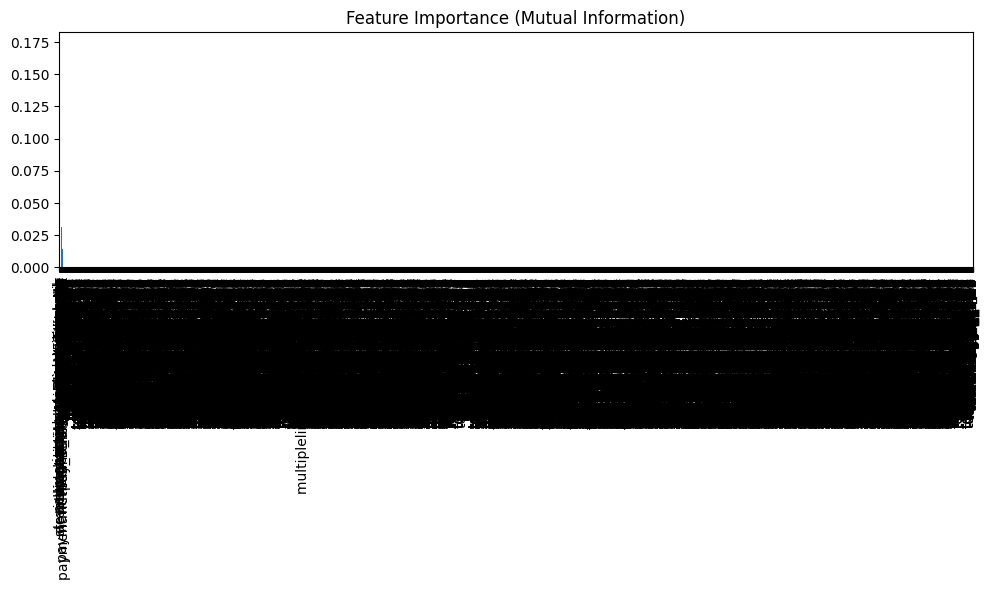

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

def load_data(file_path):
    return pd.read_csv(file_path)

def perform_eda(df):
    print("Dataset Shape:", df.shape)
    print("\nData Types:")
    print(df.dtypes)

    print("\nMissing Values:")
    print(df.isnull().sum())

    print("\nSummary Statistics:")
    print(df.describe())

    # Analyze target variable
    plt.figure(figsize=(8, 6))
    df['churn'].value_counts().plot(kind='bar')
    plt.title('Distribution of Churn')
    plt.show()

    # Analyze numeric features
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_features = [f for f in numeric_features if f not in ['customerid', 'churn']]

    plt.figure(figsize=(15, 10))
    df[numeric_features].hist(bins=20, figsize=(15, 10))
    plt.tight_layout()
    plt.show()

    # Analyze categorical features
    categorical_features = df.select_dtypes(include=[object]).columns.tolist()
    categorical_features = [f for f in categorical_features if f != 'customerid']

    for feature in categorical_features:
        plt.figure(figsize=(10, 6))
        df[feature].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {feature}')
        plt.show()

    # Correlation analysis
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

    # Feature importance using mutual information
    X = df.drop(['customerid', 'churn'], axis=1)
    y = df['churn']

    categorical_features = X.select_dtypes(include=[object]).columns.tolist()
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

    X_processed, _, feature_names = preprocess_data(X, numeric_features, categorical_features)

    mi_scores = mutual_info_classif(X_processed, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=feature_names)
    mi_scores = mi_scores.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    mi_scores.plot(kind='bar')
    plt.title('Feature Importance (Mutual Information)')
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    file_path = "/content/drive/MyDrive/churn_data/Telco-Customer-Churn.csv"  # Your file path
    df = load_data(file_path)
    perform_eda(df)

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import joblib

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)

    le = LabelEncoder()
    df['churn'] = le.fit_transform(df['churn'])

    X = df.drop(['customerid', 'churn'], axis=1)
    y = df['churn'].values
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=[object]).columns.tolist()

    X_processed, _, feature_names = preprocess_data(X, numeric_features, categorical_features)

    return X_processed, y, feature_names

def train_evaluate_and_save_model(model, X_train, X_test, y_train, y_test, model_name, model_path='model.pkl'):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"{model_name} Cross-Validation ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{model_name} Test Set Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")

    return model

def main():
    file_path = "/content/drive/MyDrive/churn data/churn_data/Telco-Customer-Churn.csv"
    X, y, feature_names = load_and_preprocess_data(file_path)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

    models = [
        ("Random Forest", rf_model),
        ("Logistic Regression", lr_model),
        ("XGBoost", xgb_model)
    ]

    for name, model in models:
        print(f"\nTraining {name}...")
        trained_model = train_evaluate_and_save_model(model, X_train, X_test, y_train, y_test, name, f"{name}_model.pkl")

        if name in ["Random Forest", "XGBoost"]:
            importances = trained_model.feature_importances_
            feature_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
            feature_imp = feature_imp.sort_values('importance', ascending=False).head(10)
            print(f"\nTop 10 Important Features for {name}:")
            print(feature_imp)

if __name__ == "__main__":
    main()



Training Random Forest...
Random Forest Cross-Validation ROC AUC: 0.8164 (+/- 0.0189)

Random Forest Test Set Metrics:
Accuracy: 0.7899
Precision: 0.6453
Recall: 0.4584
F1 Score: 0.5361
ROC AUC: 0.8348

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1036
           1       0.65      0.46      0.54       373

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409

Model saved to Random Forest_model.pkl

Top 10 Important Features for Random Forest:
                           feature  importance
1                           tenure    0.100154
2                   monthlycharges    0.083317
35         contract_Month-to-month    0.038140
42  paymentmethod_Electronic check    0.022077
17               onlinesecurity_No    0.020459
26                  techsupport_No    0.020174
37               contract_Two ye

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Cross-Validation ROC AUC: 0.8147 (+/- 0.0206)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Test Set Metrics:
Accuracy: 0.7899
Precision: 0.6215
Recall: 0.5282
F1 Score: 0.5710
ROC AUC: 0.8325

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1036
           1       0.62      0.53      0.57       373

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409

Model saved to XGBoost_model.pkl

Top 10 Important Features for XGBoost:
                        feature  importance
15  internetservice_Fiber optic    0.313978
35      contract_Month-to-month    0.313725
37            contract_Two year    0.027415
17            onlinesecurity_No    0.026998
9               phoneservice_No    0.019536
34          streamingmovies_Yes    0.017422
36            contract_One year    0.016233
14          internetservice_DSL    0.015671
26               techsupport_No    0.014949
1                        t

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/churn data/churn_data/Telco-Customer-Churn.csv")
df.sample(5)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
2859,6963-EZQEE,Male,1,Yes,No,70,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),88.55,6306.5,0
173,0691-JVSYA,Female,0,Yes,No,53,Yes,No,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Bank transfer (automatic),94.85,5000.2,1
3152,9909-DFRJA,Female,0,No,No,26,Yes,No,Fiber optic,Yes,...,Yes,Yes,No,Yes,One year,Yes,Bank transfer (automatic),95.85,2475.35,0
4725,1541-ETJZO,Male,0,No,No,1,Yes,Yes,DSL,No,...,Yes,Yes,No,No,Month-to-month,No,Mailed check,62.05,62.05,1
2326,2266-SJNAT,Female,0,Yes,No,72,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),109.15,7789.6,0


In [ ]:
df.shape

(7043, 21)

In [ ]:
df.columns.values

array(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'contract',
       'paperlessbilling', 'paymentmethod', 'monthlycharges',
       'totalcharges', 'churn'], dtype=object)

In [ ]:
df.dtypes

,0
customerid,object
gender,object
seniorcitizen,int64
partner,object
dependents,object
tenure,int64
phoneservice,object
multiplelines,object
internetservice,object
onlinesecurity,object


In [ ]:
df.describe()

,seniorcitizen,tenure,monthlycharges,churn
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,0.265370
std,0.368612,24.559481,30.090047,0.441561
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,0.000000
50%,0.000000,29.000000,70.350000,0.000000
75%,0.000000,55.000000,89.850000,1.000000
max,1.000000,72.000000,118.750000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


In [ ]:
df['churn'].value_counts()

,count
churn,
0,5174
1,1869


In [ ]:
100*df['churn'].value_counts()/len(df['churn'])

,count
churn,
0,73.463013
1,26.536987


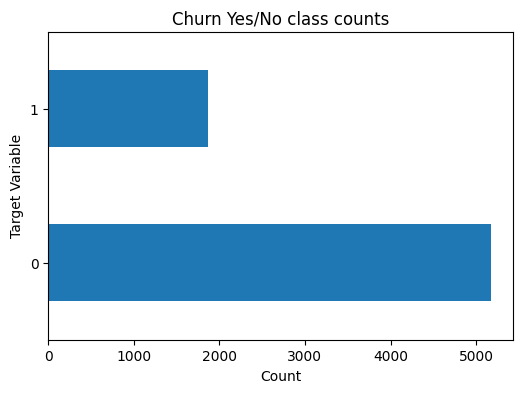

In [ ]:
df['churn'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Count")
plt.ylabel("Target Variable")
plt.title("Churn Yes/No class counts");

Data transformation & Renaming


In [ ]:
def Data_transformation_renaming(df):
    """ Rename column names and transformed into proper format and return dataframe """
    df_cal = df.copy()


    df_cal['partner'] = df_cal.partner.map({'Yes':1,'No':0})
    df_cal['dependents'] = df_cal.dependents.map({'Yes':1,'No':0})

    df_cal['phoneservice'] = df_cal.phoneservice.map({'Yes':1,'No':0})
    df_cal['multiplelines'] = df_cal.multiplelines.map({'Yes':1,'No':0,'No phone service':0})

    df_cal['internetservice'] = df_cal.internetservice.map({'DSL':1,'Fiber optic':1,'No':0})
    df_cal['onlinesecurity'] = df_cal.onlinesecurity.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['onlinebackup'] = df_cal.onlinebackup.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['deviceprotection'] = df_cal.deviceprotection.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['techsupport'] = df_cal.techsupport.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['streamingtv'] = df_cal.streamingtv.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['streamingmovies'] = df_cal.streamingmovies.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['paperlessbilling'] = df_cal.paperlessbilling.map({'Yes':1,'No':0})
    df_cal['churn'] = df_cal.churn.map({'Yes':1,'No':0})

    # Data mining
    df_cal['isContracted'] = df_cal.contract.map({'One year':1,'Two year':1,'Month-to-month':0})

    # Data transformation

    # Converting TotalCharges into Numeric, but some of the records are empty, so first we need to deal with them.
    df_cal.loc[df_cal['totalcharges']==' ','totalcharges'] = np.nan

    # First we convert TotalCharges to float and then replace with tenure * monthly charges
    df_cal['totalcharges'] = df_cal['totalcharges'].astype('float64')
    df_cal.loc[df_cal['totalcharges'].isnull()==True,'totalcharges'] = df_cal['monthlycharges'] * df_cal['tenure']


    return df_cal

In [ ]:
df_cal = Data_transformation_renaming(df)

df_cal.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,isContracted
0,7590-VHVEG,Female,0,1,0,1,0,0,1,0,...,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,NaN,0
1,5575-GNVDE,Male,0,0,0,34,1,0,1,1,...,0,0,0,One year,0,Mailed check,56.95,1889.50,NaN,1
2,3668-QPYBK,Male,0,0,0,2,1,0,1,1,...,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,NaN,0
3,7795-CFOCW,Male,0,0,0,45,0,0,1,1,...,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,NaN,1
4,9237-HQITU,Female,0,0,0,2,1,0,1,0,...,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,NaN,0


In [57]:
cat_cols = ["gender", "partner", "dependents", "seniorcitizen", "phoneservice", "multiplelines",
            "internetservice", "onlinesecurity", "onlinebackup", "deviceprotection",
            "techsupport", "streamingtv", "streamingmovies", "isContracted",
            "contract", "paperlessbilling", "paymentmethod"]

num_cols = ["tenure", "monthlycharges", "totalcharges"]

target_col = 'churn'

# Splitting categorical columns into Nominal and Binary columns
nominal_cols = ['gender', 'internetservice', 'paymentmethod', 'contract']

binary_cols = ['seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'onlinesecurity',
               'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
               'paperlessbilling', 'internetservice', 'iscontracted']

In [58]:
df_cal[cat_cols].describe(include='all')

,gender,partner,dependents,seniorcitizen,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,isContracted,contract,paperlessbilling,paymentmethod
count,7043,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043,7043.000000,7043
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,4
top,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-month,NaN,Electronic check
freq,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3875,NaN,2365
mean,NaN,0.483033,0.299588,0.162147,0.903166,0.421837,0.783331,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.449808,NaN,0.592219,NaN
std,NaN,0.499748,0.458110,0.368612,0.295752,0.493888,0.412004,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.497510,NaN,0.491457,NaN
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN
25%,NaN,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN
50%,NaN,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,NaN
75%,NaN,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,NaN


In [59]:
df_cal[num_cols].describe()

,tenure,monthlycharges,totalcharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [60]:
def Outlier_boxplot(df, col):
    """ Display boxplot for given column """
    sns.boxplot(x=df[col])
    plt.show()

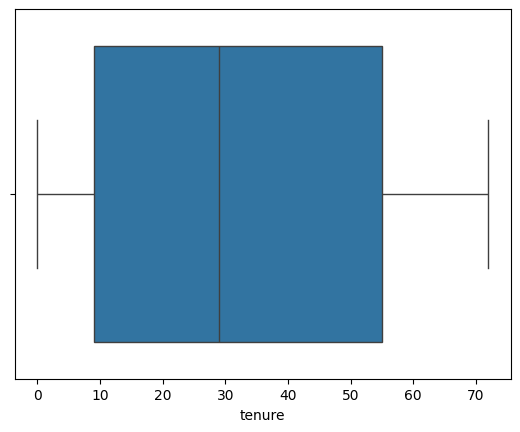

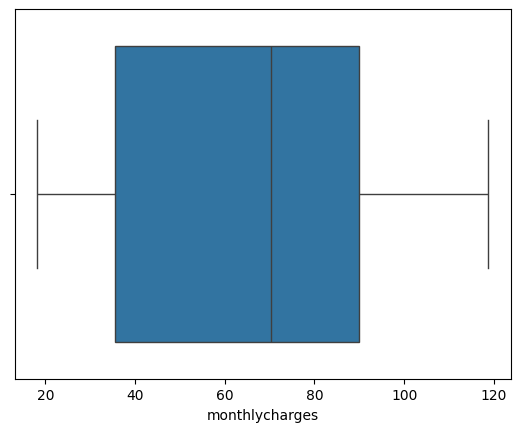

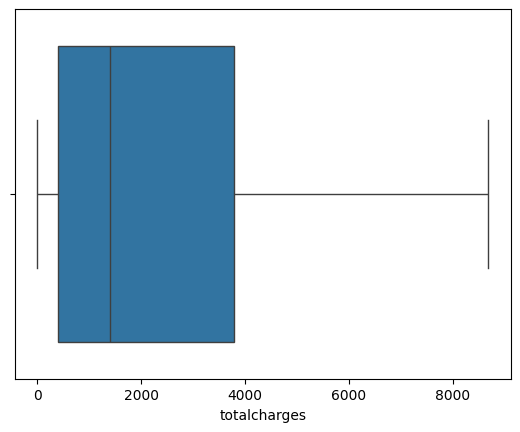

In [61]:
for i in num_cols:
    Outlier_boxplot(df_cal,i)

In [72]:
def Generate_heatmap_graph(corr, chart_title, mask_uppertri=False ):
    """ Based on features , generate correlation matrix """
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = mask_uppertri

    fig,ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr
                , mask = mask
                , square = True
                , annot = True
                , annot_kws={'size': 10.5, 'weight' : 'bold'}
                , cmap=plt.get_cmap("YlOrBr")
                , linewidths=.1)
    plt.title(chart_title, fontsize=14)
    plt.show()

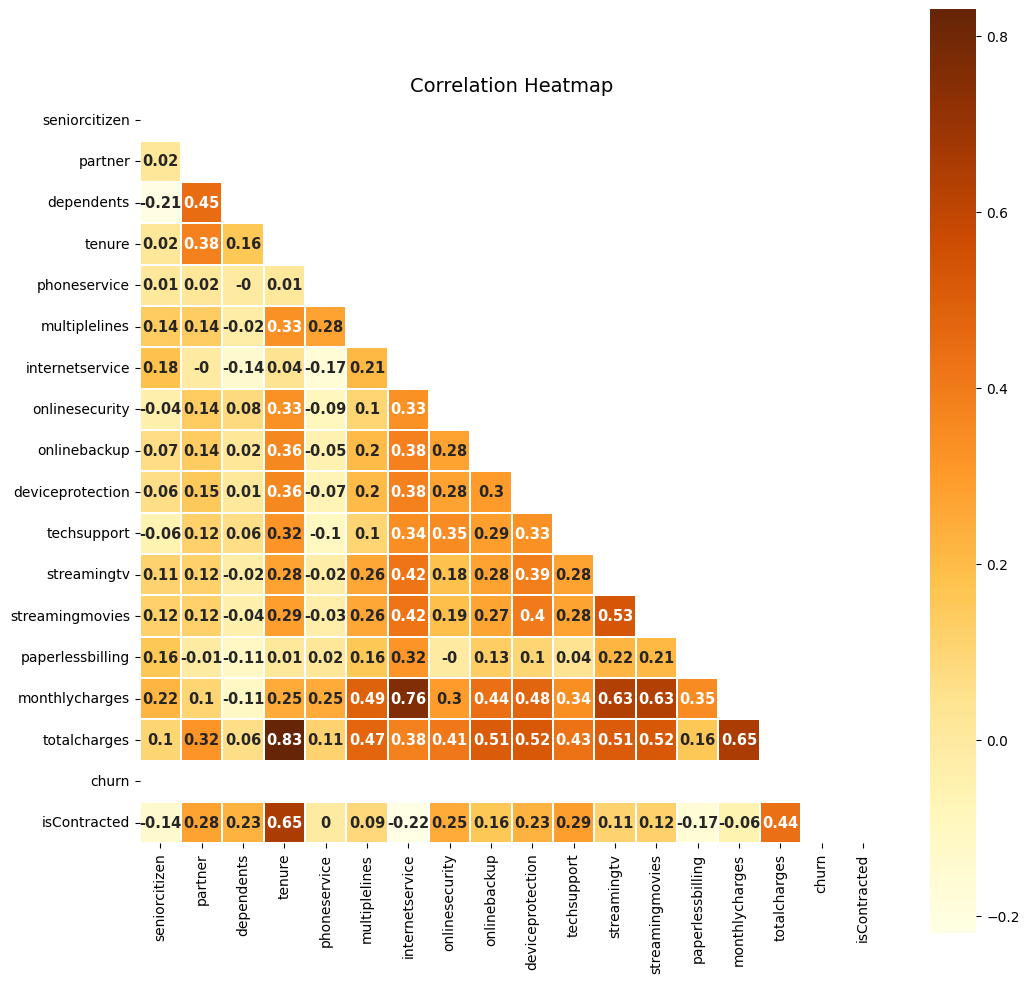

In [75]:
# Select only numeric columns for correlation
numeric_df = df_cal.select_dtypes(include=['float64', 'int64'])

# Calculate correlation on numeric columns
var_corr = round(numeric_df.corr(), 2)

# Assuming Generate_heatmap_graph is defined, generate the heatmap
Generate_heatmap_graph(
    var_corr,
    chart_title='Correlation Heatmap',
    mask_uppertri=True
)


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.countplot(data=df, x="gender", hue="churn", ax=axes[0, 0])
axes[0, 0].set_title('Count Plot: Gender by Churn')

sns.countplot(x='internetservice', hue='churn', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Count Plot: Internet Service by Churn')

sns.countplot(x='onlinesecurity', hue='churn', data=df, ax=axes[0, 2])
axes[0, 2].set_title('Count Plot: Online Security by Churn')

sns.countplot(x='contract', hue='churn', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Count Plot: Contract by Churn')

sns.countplot(x='paymentmethod', hue='churn', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Count Plot: Payment Method by Churn')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)

sns.barplot(x='churn', y='tenure', data=df, ax=axes[1, 2])
axes[1, 2].set_title('Bar Plot: Tenure by Churn')

plt.tight_layout()
plt.show()

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_data_label(ax):
    """Display data label for given axis"""
    for bar in ax.patches:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{bar.get_height():.2%}",
            ha='center',
            va='bottom',
            fontsize=10
        )

def categorical_var_churn_dist(data, cols, distribution_col, plotColor=['#1f77b4', '#ff7f0e']):
    """Distribution of categorical variable based on target variable"""
    for feature in cols:
        feature_summary = data.groupby([distribution_col, feature]).size().unstack(fill_value=0)
        feature_summary = feature_summary.div(feature_summary.sum(axis=1), axis=0).reset_index()
        feature_summary_melted = feature_summary.melt(id_vars=[distribution_col], var_name=feature, value_name='Percentage')

        plt_cat = sns.catplot(
            x=feature,
            y='Percentage',
            col=distribution_col,
            data=feature_summary_melted,
            kind='bar',
            aspect=0.8,
            palette=plotColor,
            alpha=0.6,
            height=5
        )

        if feature == 'PaymentMethod':
            plt_cat.set_xticklabels(rotation=45, ha='right')

        for ax in plt_cat.axes.flatten():
            create_data_label(ax)
            ax.set_ylim(0, 1)

        plt_cat.set_axis_labels(feature, 'Percentage')
        plt_cat.fig.suptitle(f"{feature} distribution", fontsize=14)
        plt_cat.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect parameter as needed
        plt.show()


<ipython-input-91-8ed3eaec826e>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plt_cat = sns.catplot(
<ipython-input-91-8ed3eaec826e>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plt_cat = sns.catplot(
<ipython-input-91-8ed3eaec826e>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plt_cat = sns.catplot(
<ipython-input-91-8ed3eaec826e>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plt_cat = sns.catplot(
<ipython-input-91-8ed3eaec826e>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plt_cat = sns.catplot(
<ipython-input-91-8ed3eaec826e>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plt_cat = sns.catplot(
<ipython-input-91-8ed3eaec826e>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plt_cat = sns.catplot(
<ipython-input-91-8ed3eaec826e>:22

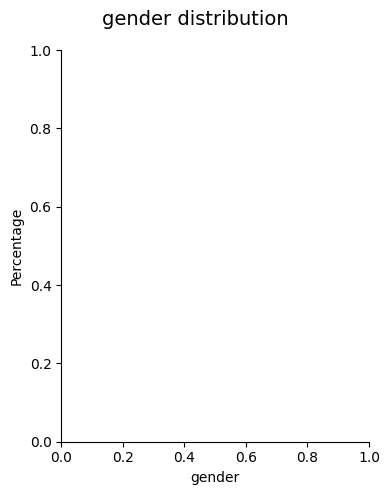

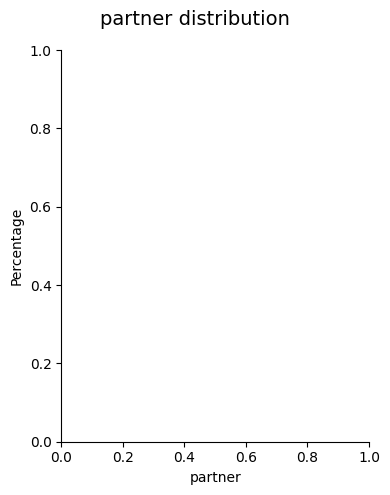

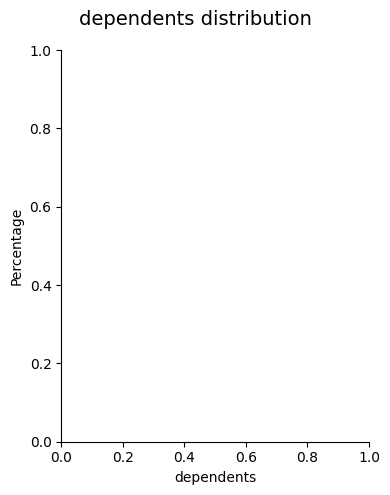

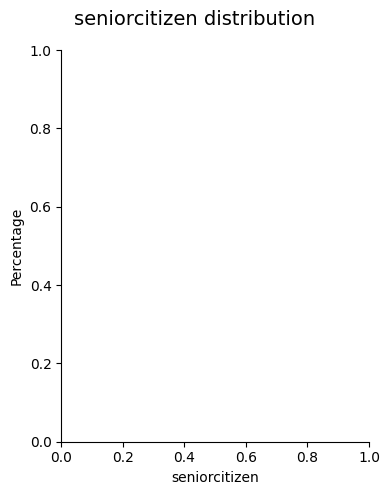

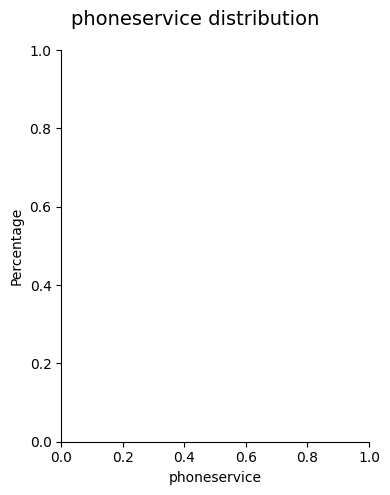

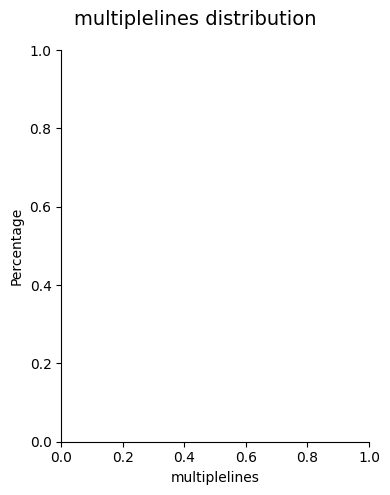

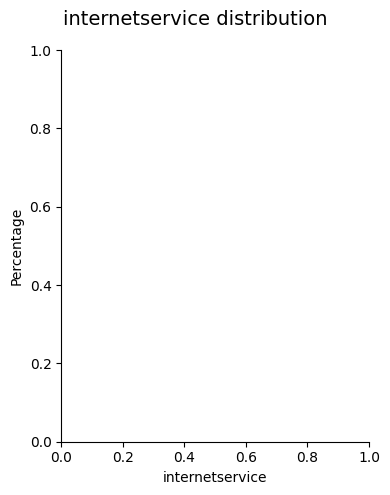

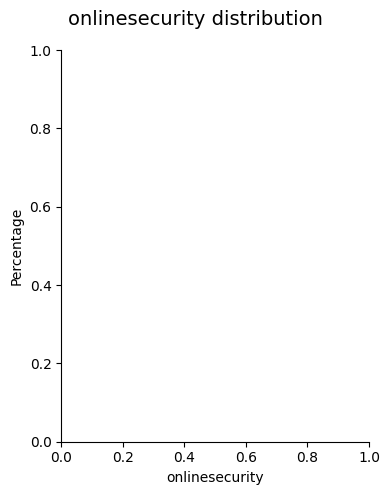

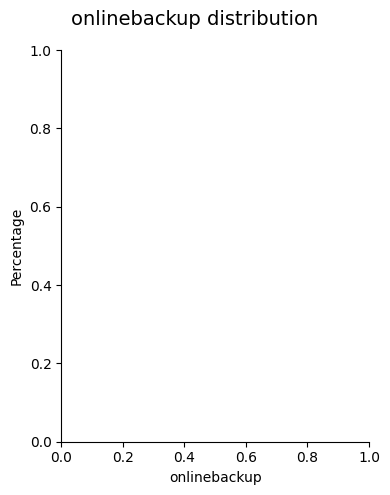

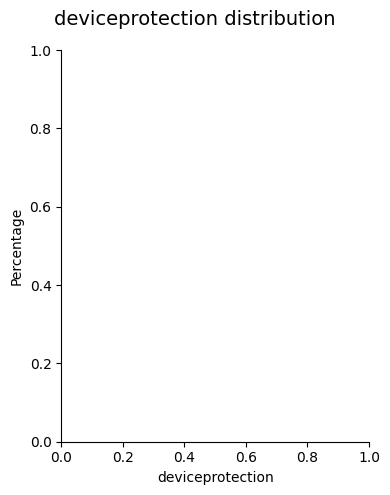

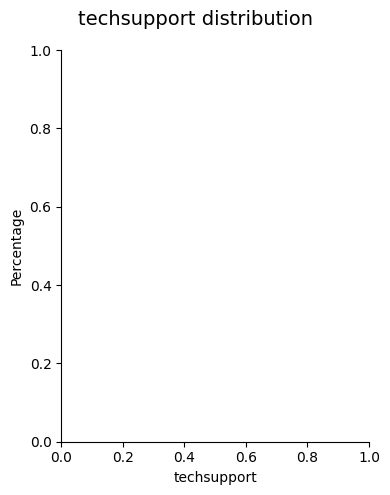

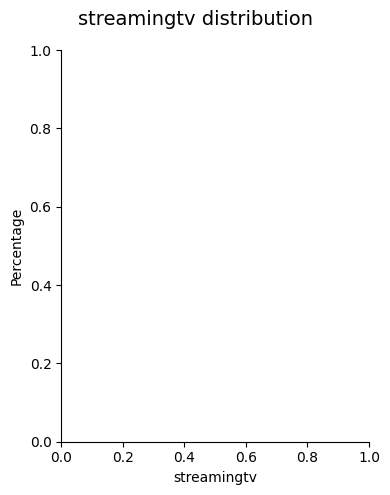

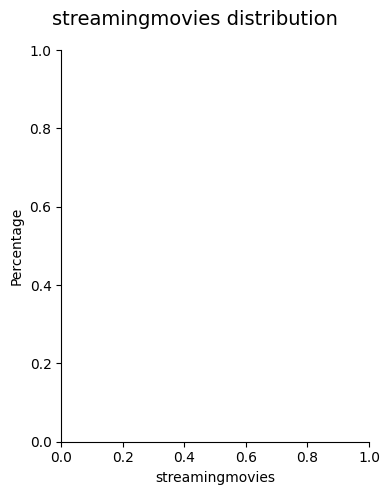

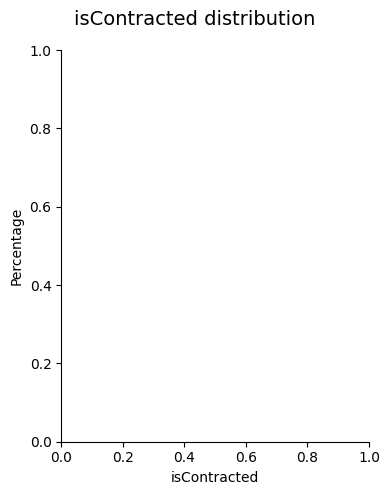

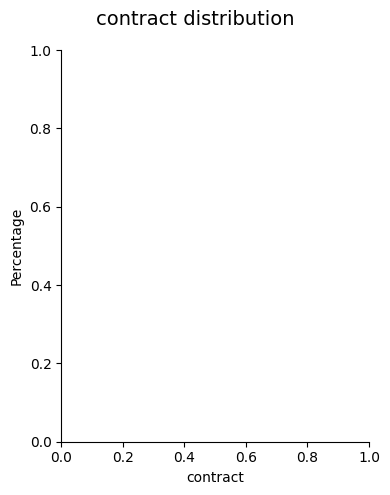

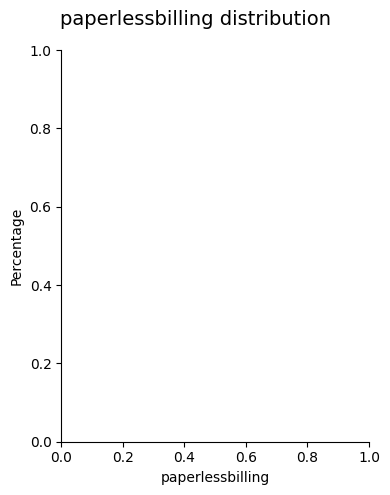

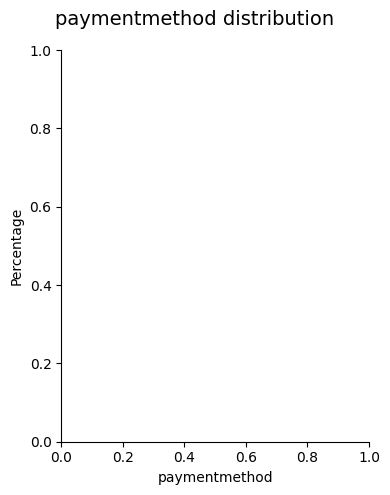

In [104]:


Categorical_var_churn_dist(df_cal, cat_cols, 'churn')


Numeric Data Analysis

In [98]:
def Numerical_distribution(df_cal, feature):
    """ Distribution of numerical variable based on target variable """
    fig = plt.figure(figsize=(15,10))

    # First subplot for the overall distribution
    plt.subplot(2,1,1)
    sns.kdeplot(df_cal[feature], color='g', fill=True)  # Updated: fill=True replaces shade=True
    plt.title("Original " + feature + " Distribution")

    # Second subplot for Churn vs No Churn distribution
    plt.subplot(2,1,2)
    ax = sns.kdeplot(df_cal.loc[df_cal['churn']==1, feature], color='g', fill=True, label='Churn')  # Updated
    sns.kdeplot(df_cal.loc[df_cal['churn']==0, feature], color='b', fill=True, label='No Churn')  # Updated

    plt.title(feature + " Distribution: Churn vs No churn")
    plt.legend(title='Churn Status')  # Add legend with a title
    plt.show()


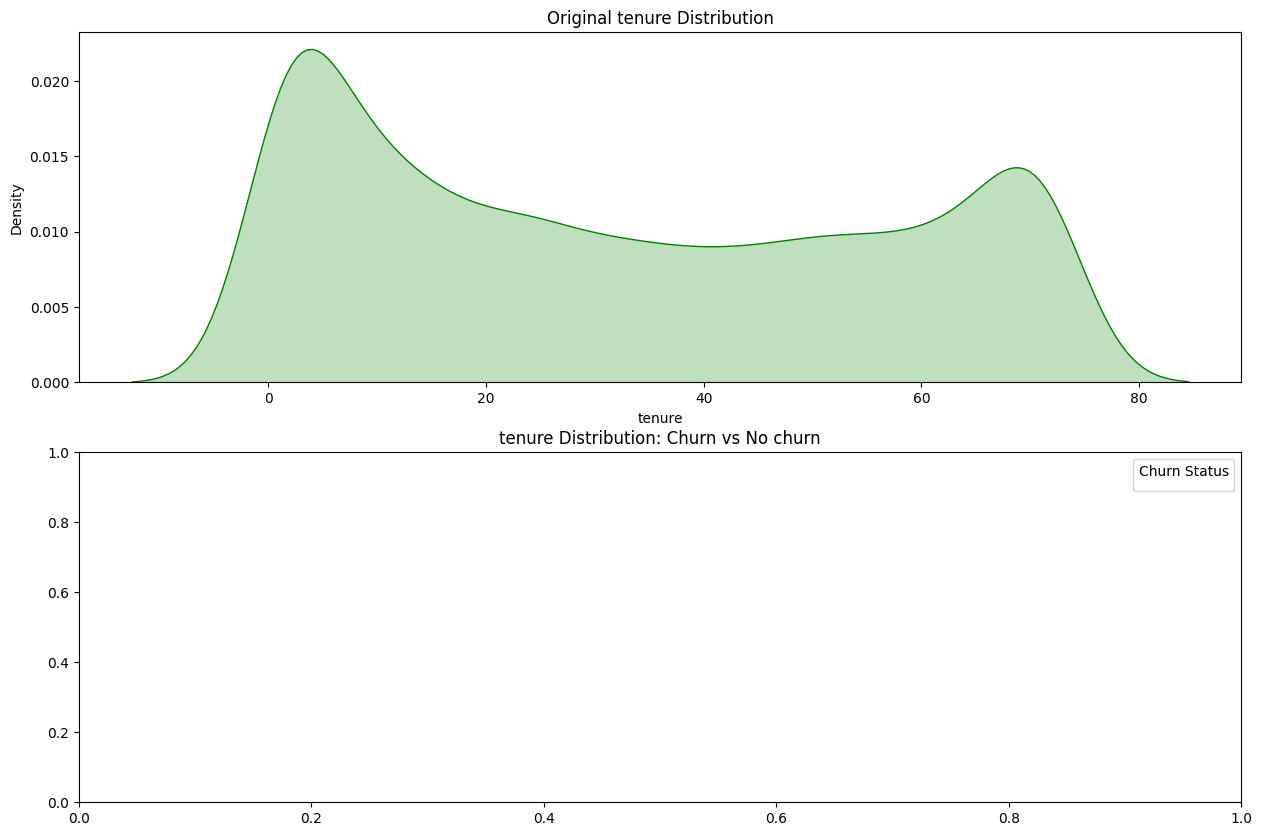

In [99]:
Numerical_distribution(df_cal,'tenure')

<ipython-input-82-a5f53aba982e>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df_cal[feature]
<ipython-input-82-a5f53aba982e>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df_cal.loc[(df_cal['churn']==1),feature]
<ipython-input-82-a5f53aba982e>:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df_cal.loc[(df_cal['churn']==0) ,feature]


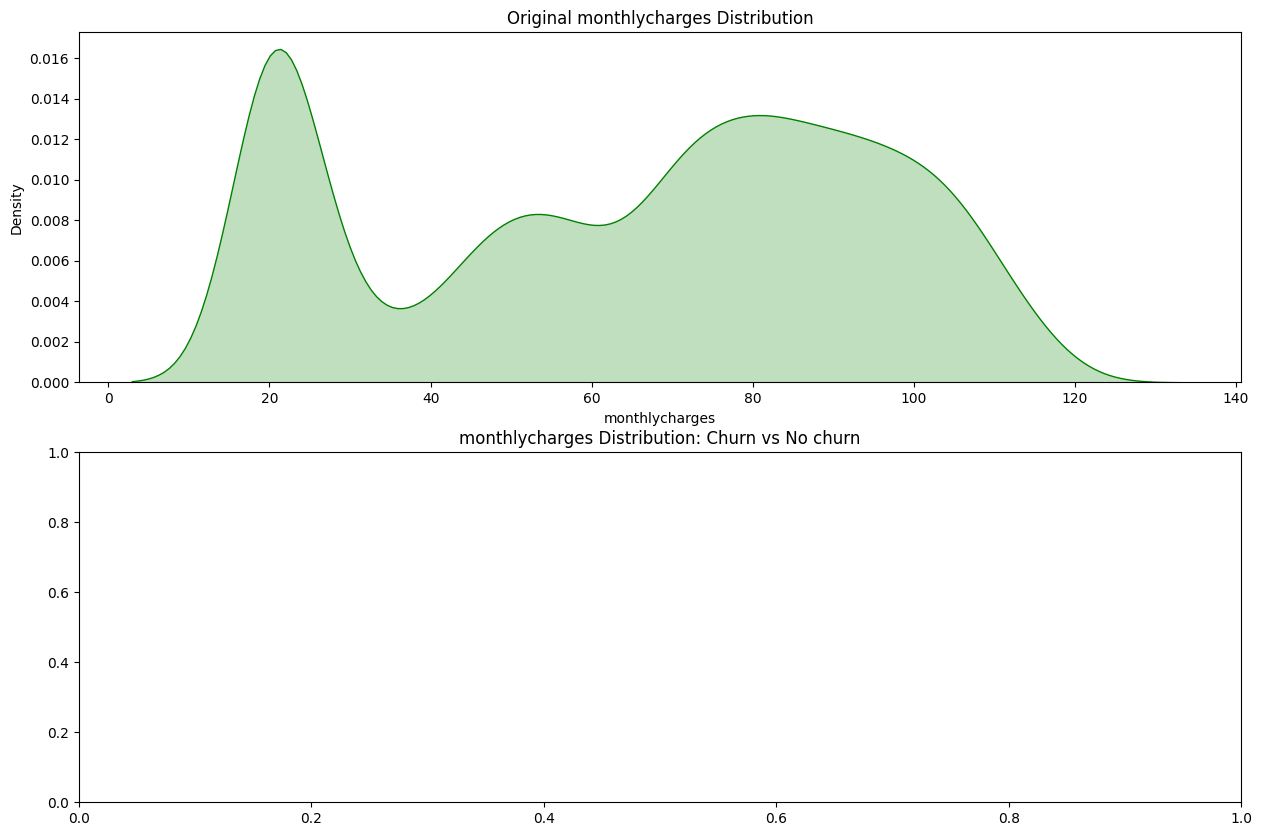

In [84]:
Numerical_distribution(df_cal,'monthlycharges')

<ipython-input-82-a5f53aba982e>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df_cal[feature]
<ipython-input-82-a5f53aba982e>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df_cal.loc[(df_cal['churn']==1),feature]
<ipython-input-82-a5f53aba982e>:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df_cal.loc[(df_cal['churn']==0) ,feature]


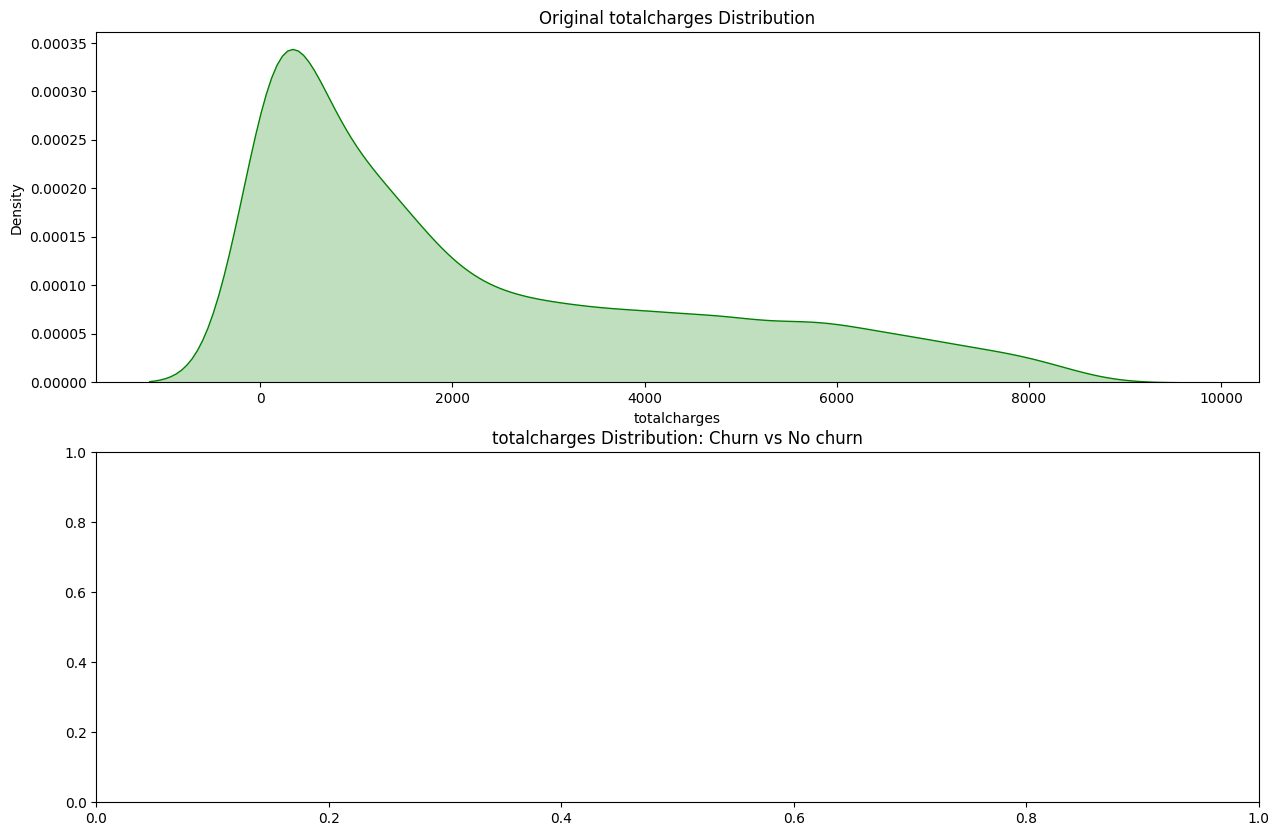

In [87]:
Numerical_distribution(df_cal,'totalcharges')

Model Training

In [120]:
from sklearn.utils import shuffle
import sklearn.preprocessing  as prepro
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import resample
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
random_state=42

In [111]:
df_model = Data_transformation_renaming(df)
df_model.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,isContracted
0,7590-VHVEG,Female,0,1,0,1,0,0,1,0,...,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,NaN,0
1,5575-GNVDE,Male,0,0,0,34,1,0,1,1,...,0,0,0,One year,0,Mailed check,56.95,1889.50,NaN,1
2,3668-QPYBK,Male,0,0,0,2,1,0,1,1,...,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,NaN,0
3,7795-CFOCW,Male,0,0,0,45,0,0,1,1,...,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,NaN,1
4,9237-HQITU,Female,0,0,0,2,1,0,1,0,...,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,NaN,0


In [118]:
def Shuffle_data(df):
    """ Return shuffled data based on rows """
    return shuffle(df).reset_index().drop('index'
                                          , axis = 1)

def One_hot_encoding(df,feature):
    """ Apply one hot encoding to given features """
    return pd.concat([df
                      , pd.get_dummies(df[feature])]
                     , axis = 1)

def Merge_df(data, features):
    """ Return merge dataframe with given features"""
    merged_df = pd.DataFrame()
    for feature in features:
        merged_df = pd.concat([merged_df, data[feature]]
                              , axis = 1)
    return merged_df

def Normalize_feature(feature):
    """ Return normalized features """
    return prepro.StandardScaler().fit_transform(feature)

def Normalize_df(data, cols):
    """ Normalize features """
    for col in cols:
        data[col] = Normalize_feature(data[[col]])

    return data

def Create_model_df(df, col_cols, nom_cols, binary_cols, num_cols, target_col):
    """ Preparing data for modelling """

    df_model = Merge_df(df , [col_cols, num_cols, target_col])
    df_model = Shuffle_data(df_model)
    df_model = One_hot_encoding(df_model, nom_cols)

    df_model.drop(nom_cols, axis = 1, inplace = True)

    df_model = Normalize_df(df_model, num_cols)

    return (df_model.loc[:, ~df_model.columns.isin(target_col)]
            , df_model[target_col].values.flatten())


def Train_test_df(feature, target, test_size):
    """ Spliting data to train and test"""
    return train_test_split(feature
                     ,target
                     ,test_size= test_size
                     ,random_state= random_state)

In [121]:
df_model_feature ,df_model_target = Create_model_df(df_model
                                                    , cat_cols
                                                    , nominal_cols
                                                    , binary_cols
                                                    , num_cols
                                                    , [target_col])

x_train, x_test, y_train, y_test = Train_test_df(df_model_feature
                                                 , df_model_target
                                                 , test_size = 0.2)


print("----------------------------")
print("Original features shape, ", df_model_feature.shape)
print("Original target shape, ", df_model_target.shape)
print("x train shape, ", x_train.shape)
print("y train shape, ", y_train.shape)
print("x test shape, ", x_test.shape)
print("y test shape, ", y_test.shape)
print("----------------------------")

----------------------------
Original features shape,  (7043, 25)
Original target shape,  (7043,)
x train shape,  (5634, 25)
y train shape,  (5634,)
x test shape,  (1409, 25)
y test shape,  (1409,)
----------------------------


In [128]:
def Parameter_tunning(x, y, models, clsModelsNm, parameters, score):

    tuned_params = {}
    for i,model in enumerate(models):
        print(clsModelsNm[i])
        grid = GridSearchCV(estimator = model
                            , cv = 5
                            , param_grid = parameters[clsModelsNm[i]]
                            , scoring = score
                            , n_jobs = 3)
        grid.fit(x,y)
        print(grid.best_score_)
        print(grid.best_params_)
        tuned_params[clsModelsNm[i]] = {'params':grid.best_params_}

    return tuned_params

In [129]:
clsModelsNm = ["Logistic Regression", "Random Forest", "Gradient boosting"]
scoreMatrix = ['accuracy','precision','recall','f1','neg_log_loss']

clsParams = {'Logistic Regression':{'C':[0.1, 0.5, 1, 5, 10, 15, 20, 100]
                                   ,'penalty':['l1','l2']
                                    }
             , 'Random Forest': {'max_depth':[3,5,7,10,15,20]
                                ,'n_estimators':[100,150,200]
                                ,'max_features':['auto',0.7,0.2]
                                ,'min_samples_leaf':[1,5,10,15,20]
                                 }
             , 'Gradient boosting': {'learning_rate': [0.05, 0.1, 0.2]
                                    ,'n_estimators':[10,50,100,150,200]
                                    ,'max_depth':[3,5,7]
                                    ,'min_samples_split':[0.1, 0.5, 1.0]
                                    ,'min_samples_leaf':[1, 5, 10, 15, 20]
                                    ,'subsample': [0.1, 0.5, 0.7 , 1]
                                    }
            }